<a href="https://colab.research.google.com/github/alizedan1/-COMP472_Project/blob/main/Image_Classification_CIFAR10_COMP472.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Installing pytorch using command given on https://pytorch.org/get-started/locally/

!pip install torch torchvision torchaudio


# Preprocessing

In [2]:
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#transform the dataset we first have to transform the dataset by resizing it and then normalizing it,
#we call Compose function in the transforms library and call Resize and Normalize. This transform attribute will be sent to
# as a parameter to .CIFAR10 and will tranform all the data.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load the data, training data will be True and test data which will be tested will be False in the
#train attribute.

training_data = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

# To make this possible "In this project, you will only use 500 training images and 100 test images per class. Therefore, your first
#task is to load the dataset and use the first 500 training images, and the first 100 test images of each
#class." we need to create a function which will return the indices of the first amount of objects
#inpted. If we want 50 we will but 50 training etc.

def get_Class_indices(dataset, samples_per_class, num_classes=10):
    class_indices = {i: []
                     for i in range(num_classes)}

    for index, (_, label) in enumerate(dataset):
        class_indices[label].append(index)

    subset_indices = []
    for class_id in range(num_classes):
        subset_indices.extend(class_indices[class_id][:samples_per_class])

    return subset_indices

#We call this function inputting 500 training data and 100 training for each class
training_indices = get_Class_indices(training_data, 500)
testing_indices = get_Class_indices(test_data, 100)

#We create a subset of each data
train_subset = Subset(training_data, training_indices)
test_subset = Subset(test_data, testing_indices )


#We load the data by batches, we will create batches of 32 to start off and see its precision
train_loader = DataLoader(train_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Feature Extraction using Pre-trained ResNet-18
# This part was generated by GPT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Identity()  # Remove the final fully connected layer
resnet18 = resnet18.to(device)
resnet18.eval()

def extract_features(loader):
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = resnet18(images)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels


# Here with the function declared we call it to extract features for the training data and
#the features for the testing data

x_train, y_train = extract_features(train_loader)
x_test, y_test = extract_features(test_loader)

# Reduction with PCA
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

print("Shape of training data after PCA:", x_train_pca.shape)
print("Shape of test data after PCA:", x_test_pca.shape)



100%|██████████| 170M/170M [00:18<00:00, 9.31MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Shape of training data after PCA: (5000, 50)
Shape of test data after PCA: (1000, 50)


# Naives Bayes Implementation

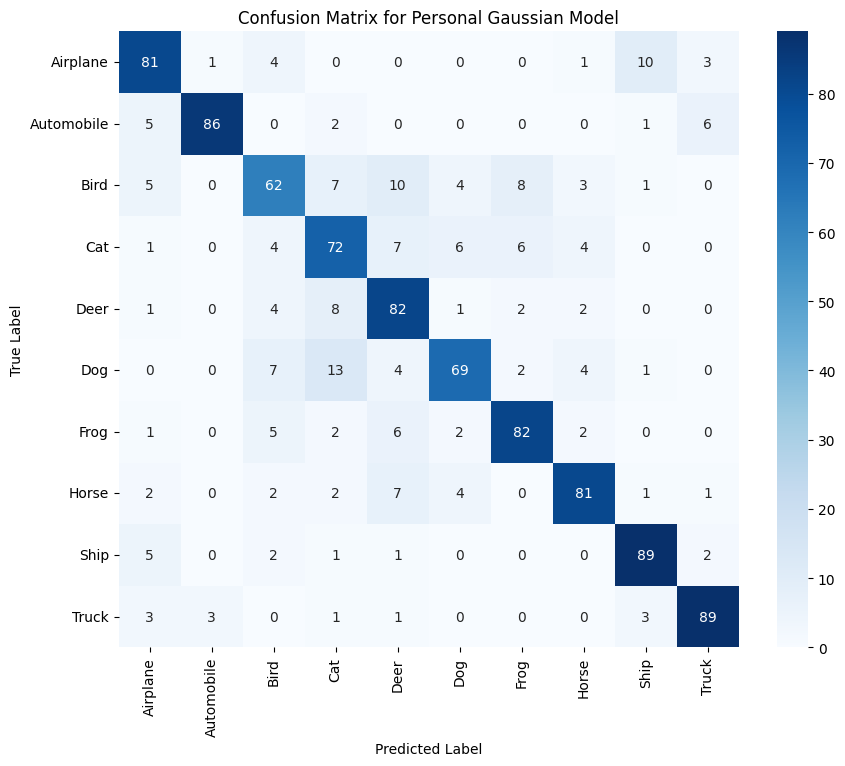

Performance Metrics for Personal Gaussian Model:
Accuracy: 0.7930
Precision: 0.7963
Recall: 0.7930
F1-Score: 0.7931


In [48]:
# Gaussian implementation

class Gaussian:
  def __init__(self):
    self.means = None
    self.variances = None
    self.priors = None

  def fit(self, X, y):
    n_classes = len(np.unique(y))
    n_features = X.shape[1]

    self.means = np.zeros((n_classes, n_features))
    self.variances = np.zeros((n_classes, n_features))
    self.priors = np.zeros(n_classes)

    for c in range(n_classes):
            X_c = X[y == c]
            self.means[c, :] = np.mean(X_c, axis=0)
            self.variances[c, :] = np.var(X_c, axis=0) + 1e-6
            self.priors[c] = X_c.shape[0] / X.shape[0]

  def predict(self, X):

        log_likelihoods = self._calculate_log_likelihood(X)
        return np.argmax(log_likelihoods, axis=1)

  def _calculate_log_likelihood(self, X):

        n_samples, n_features = X.shape
        n_classes = self.means.shape[0]
        log_likelihoods = np.zeros((n_samples, n_classes))

        for c in range(n_classes):
            mean = self.means[c, :]
            variance = self.variances[c, :]
            prior = self.priors[c]

            log_gaussian = -0.5 * np.sum(
                np.log(2 * np.pi * variance) + ((X - mean) ** 2) / variance, axis=1
            )
            log_likelihoods[:, c] = log_gaussian + np.log(prior)

        return log_likelihoods

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# CIFAR-10 class labels
class_labels = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

def evaluate_model(model, X_test, y_test, class_labels, model_name="Personal Gaussian Model"):

    # Predict the labels for the test set
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    # Print metrics
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

gaussian_model = Gaussian()
gaussian_model.fit(x_train_pca, y_train)  # Fit the model (replace X_train and y_train with your data)

# Evaluate the model
results = evaluate_model(gaussian_model, x_test_pca, y_test, class_labels)




In [53]:
gnb = Gaussian()
gnb.fit(x_train_pca, y_train)

# Predict on the test set
y_pred_impl = gnb.predict(x_test_pca)

# Calculate accuracy
accuracy = np.mean(y_pred_impl == y_test)
print("Test Accuracy for Personal Implementation:", accuracy)


Test Accuracy for Sklearn Implementation: 0.793


# Naives Bayes Scikit Learn Implementation

Test Accuracy for Sklearn Implemnetation: 0.793


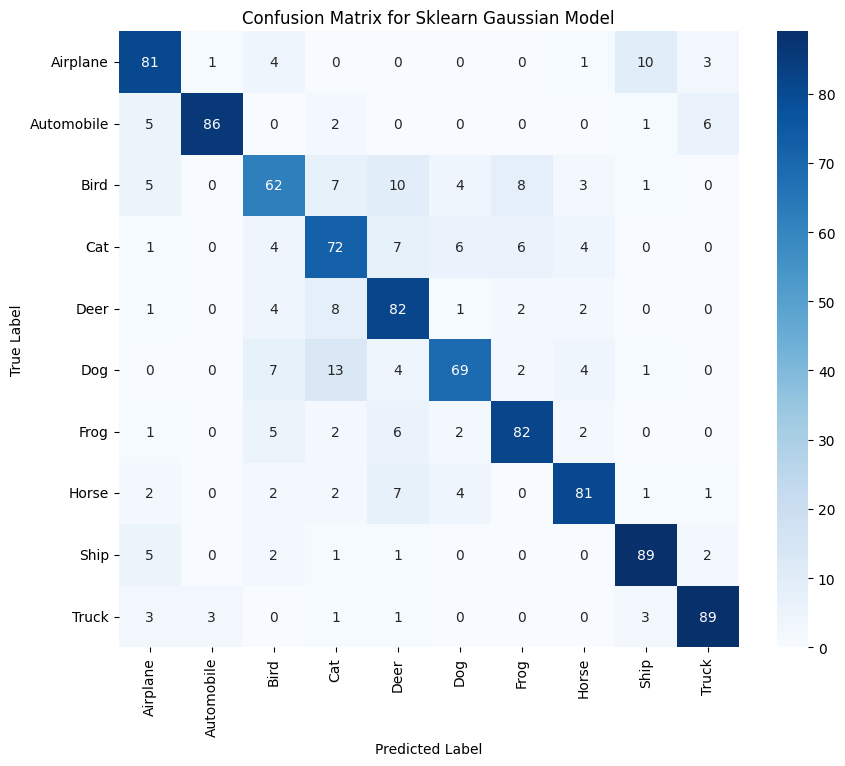

Performance Metrics for Sklearn Gaussian Model:
Accuracy: 0.7930
Precision: 0.7963
Recall: 0.7930
F1-Score: 0.7931


In [54]:
# Now let's check with the sklearn implentation of GaussianNB algorithm and compare with our implementation

from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(x_train_pca, y_train)

# Predict on the test set
y_pred = GNB.predict(x_test_pca)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print("Test Accuracy for Sklearn Implemnetation:", accuracy)

def evaluate_model(model, X_test, y_test, class_labels, model_name="Sklearn Gaussian Model"):

    # Predict the labels for the test set
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    # Print metrics
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

gaussian_model = GaussianNB()
gaussian_model.fit(x_train_pca, y_train)

# Evaluate the model
results = evaluate_model(gaussian_model, x_test_pca, y_test, class_labels)






In [6]:
#Now we can generate the confusion matrix for the bayes implemntaion

#from sklearn import metrics
#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
#import seaborn as sns
#import matplotlib.pyplot as plt

#confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
#cm_display.plot()
#plt.show()


In [8]:
f1_score(y_test, y_pred, average='weighted')

0.7930533972648346

# Decision Tree Implementation

In [11]:
import numpy as np

# Define the Node class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Gini impurity calculation
def calculate_gini_impurity(y):
    if len(y) == 0:
        return 0
    unique_classes, class_counts = np.unique(y, return_counts=True)
    probabilities = class_counts / len(y)
    impurity = 1 - np.sum(probabilities**2)
    return impurity

# Split data based on feature index and threshold
def split_data(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    left_X = X[left_mask]
    left_y = y[left_mask]
    right_X = X[right_mask]
    right_y = y[right_mask]
    return left_X, left_y, right_X, right_y

# Find the best feature and threshold to split the data
def find_best_split(X, y):
    best_gini = float('inf')
    best_feature = None
    best_threshold = None
    n_features = X.shape[1]
    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            left_X, left_y, right_X, right_y = split_data(X, y, feature_index, threshold)
            gini_left = calculate_gini_impurity(left_y)
            gini_right = calculate_gini_impurity(right_y)
            weighted_gini = (len(left_y) / len(y)) * gini_left + (len(right_y) / len(y)) * gini_right
            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_feature = feature_index
                best_threshold = threshold
    return best_feature, best_threshold

# Build the decision tree recursively
def build_tree(X, y, max_depth, current_depth=0):
    if current_depth == max_depth or len(np.unique(y)) == 1 or len(y) == 0:
        # Create a leaf node with the most frequent class
        unique, counts = np.unique(y, return_counts=True)
        most_frequent_class = unique[np.argmax(counts)]
        return Node(value=most_frequent_class)
    best_feature, best_threshold = find_best_split(X, y)
    if best_feature is None:
        unique, counts = np.unique(y, return_counts=True)
        most_frequent_class = unique[np.argmax(counts)]
        return Node(value=most_frequent_class)
    left_X, left_y, right_X, right_y = split_data(X, y, best_feature, best_threshold)
    left_subtree = build_tree(left_X, left_y, max_depth, current_depth + 1)
    right_subtree = build_tree(right_X, right_y, max_depth, current_depth + 1)
    return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

# Predict a single instance using the decision tree
def predict_tree(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)



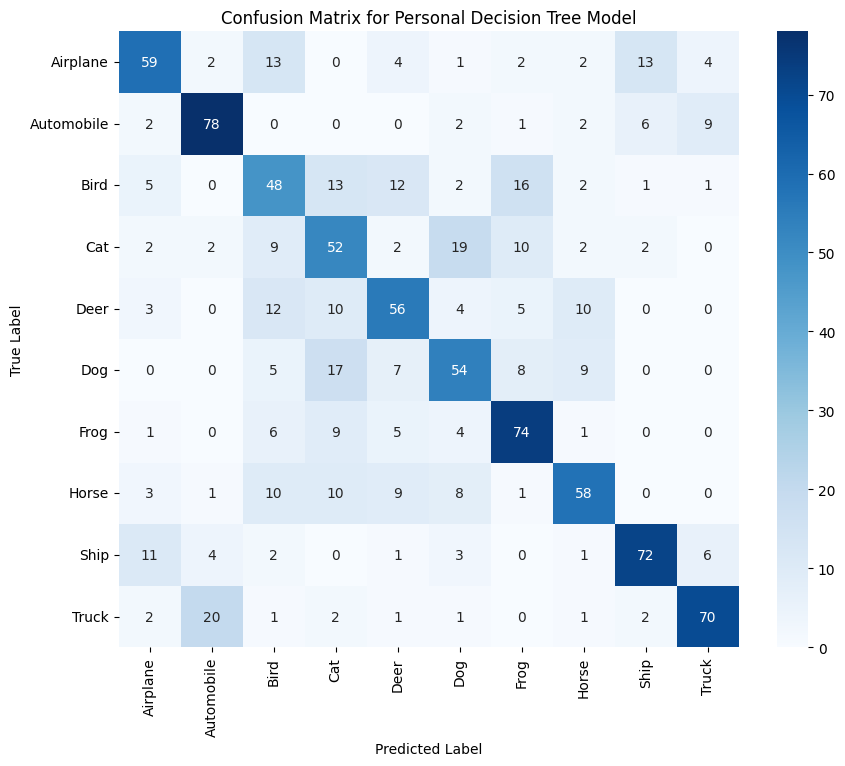

Performance Metrics for Personal Decision Tree Model:
Accuracy: 0.6210
Precision: 0.6260
Recall: 0.6210
F1-Score: 0.6220


In [56]:
def evaluate_model(model, X_test, y_test, class_labels, model_name):

    y_pred_dt = np.array([predict_tree(tree, x) for x in x_test_pca])

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_dt)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_dt)
    precision = precision_score(y_test, y_pred_dt, average="macro")
    recall = recall_score(y_test, y_pred_dt, average="macro")
    f1 = f1_score(y_test, y_pred_dt, average="macro")

    # Print metrics
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

max_depth = 50
tree = build_tree(x_train_pca, y_train, max_depth)

# Evaluate the model
model_name = "Personal Decision Tree"
results = evaluate_model(tree, x_test_pca, y_test, class_labels, model_name)







# Decision Tree Scikit Learn Implementation

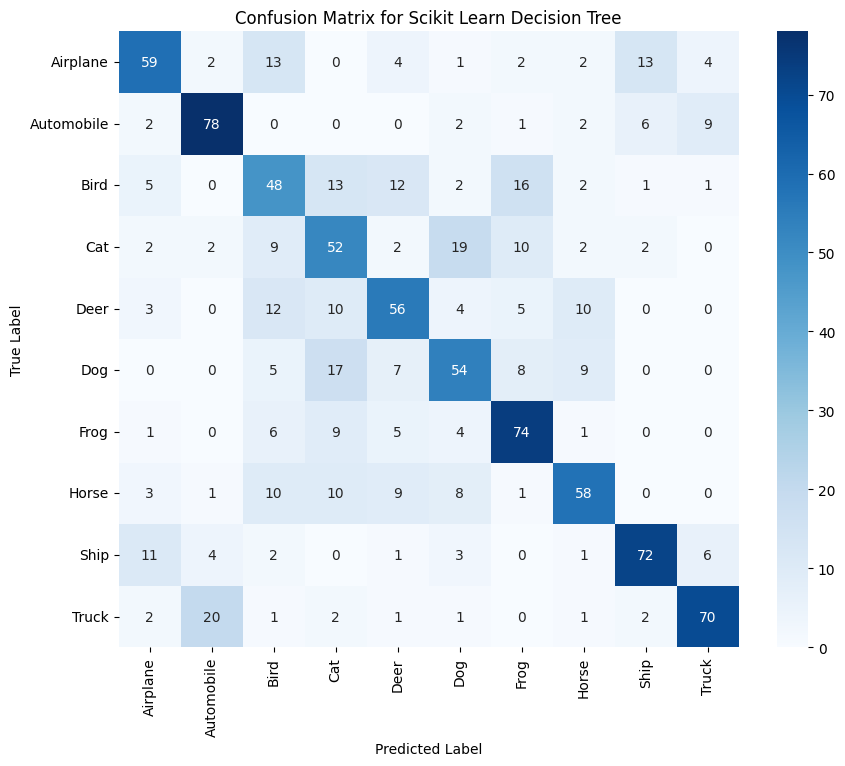

Performance Metrics for Scikit Learn Decision Tree:
Accuracy: 0.6210
Precision: 0.6260
Recall: 0.6210
F1-Score: 0.6220


In [59]:
max_depth = 50
tree_sklearn =  DecisionTreeClassifier(max_depth=max_depth, criterion="gini", random_state=42)


# Evaluate the model
model_name = "Scikit Learn Decision Tree"
results = evaluate_model(tree_sklearn, x_test_pca, y_test, class_labels,model_name)


In [13]:
#sklearn decision tree implementation

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_depths = [5, 10, 20, 30, 40, 50]

# Store the results
depth_accuracies = []

# Loop through each depth, train the model, and evaluate accuracy
for depth in tree_depths:
    # Initialize and train the decision tree classifier
    dtc = DecisionTreeClassifier(max_depth=depth, criterion="gini", random_state=42)
    dtc.fit(x_train_pca, y_train)

    # Predict on the test data
    y_pred = dtc.predict(x_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    depth_accuracies.append((depth, accuracy))
    print(f"Depth: {depth}, Accuracy: {accuracy:.4f}")

# Display the results
print("\nTree Depth vs Accuracy:")
for depth, acc in depth_accuracies:
    print(f"Max Depth: {depth}, Accuracy: {acc:.4f}")








Depth: 5, Accuracy: 0.5670
Depth: 10, Accuracy: 0.6130
Depth: 20, Accuracy: 0.6120
Depth: 30, Accuracy: 0.6120
Depth: 40, Accuracy: 0.6120
Depth: 50, Accuracy: 0.6120

Tree Depth vs Accuracy:
Max Depth: 5, Accuracy: 0.5670
Max Depth: 10, Accuracy: 0.6130
Max Depth: 20, Accuracy: 0.6120
Max Depth: 30, Accuracy: 0.6120
Max Depth: 40, Accuracy: 0.6120
Max Depth: 50, Accuracy: 0.6120


# MLP Implementation

Epoch 1/20, Loss: 0.7503
Epoch 2/20, Loss: 0.3939
Epoch 3/20, Loss: 0.3194
Epoch 4/20, Loss: 0.2671
Epoch 5/20, Loss: 0.2091
Epoch 6/20, Loss: 0.1579
Epoch 7/20, Loss: 0.1327
Epoch 8/20, Loss: 0.1043
Epoch 9/20, Loss: 0.0798
Epoch 10/20, Loss: 0.0596
Epoch 11/20, Loss: 0.0462
Epoch 12/20, Loss: 0.0343
Epoch 13/20, Loss: 0.0328
Epoch 14/20, Loss: 0.0423
Epoch 15/20, Loss: 0.0400
Epoch 16/20, Loss: 0.0447
Epoch 17/20, Loss: 0.0397
Epoch 18/20, Loss: 0.0228
Epoch 19/20, Loss: 0.0156
Epoch 20/20, Loss: 0.0139
Test Accuracy: 83.20%


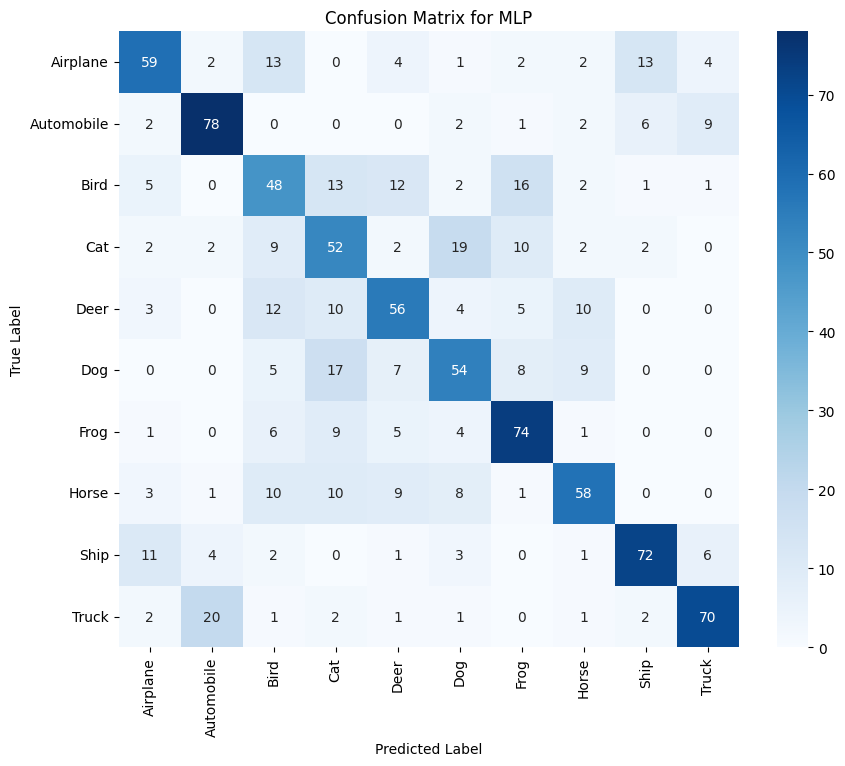

Performance Metrics for MLP:
Accuracy: 0.6210
Precision: 0.6260
Recall: 0.6210
F1-Score: 0.6220


In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# First we have to define the MLP architecture described in the project scope
# first layer is of 50 neurons, second layer is 512 and third layer is 10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        #create the model self.model initialize the model
        self.model = nn.Sequential(
            nn.Linear(50, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

# Prepare datasets for training and testing

train_dataset = TensorDataset(torch.tensor(x_train_pca, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test_pca, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# This part was generated by GPT to make space if no space in gpt convert to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP().to(device)

#criterion we use CrossEntropyLoss like describde in the project scope
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)

# We can start by trying the model by making a first pass of 20 epochs. We will set
#the first set of implementations to 20 epochs
epochs = 20

# Set the model to training
mlp_model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # We first start by a forward pass where the outputs of the previous layer are
        # the inputs of future layers         outputs = mlp_model(features)

        outputs = mlp_model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluating the MLP
mlp_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = mlp_model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")
model_name = "MLP"
results = evaluate_model(mlp_model, x_test_pca, y_test, class_labels,model_name)

# Reduced MLP

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# First we have to define the MLP architecture described in the project scope
# first layer is of 50 neurons, second layer is 512 and third layer is 10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        #create the model self.model initialize the model
        self.model = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        return self.model(x)

# Prepare datasets for training and testing

train_dataset = TensorDataset(torch.tensor(x_train_pca, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test_pca, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# This part was generated by GPT to make space if no space in gpt convert to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP().to(device)

#criterion we use CrossEntropyLoss like describde in the project scope
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)

# We can start by trying the model by making a first pass of 5 epochs
epochs = 20

# Set the model to training
mlp_model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # We first start by a forward pass where the outputs of the previous layer are
        # the inputs of future layers         outputs = mlp_model(features)

        outputs = mlp_model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluating the MLP
mlp_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = mlp_model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch 1/20, Loss: 0.6765
Epoch 2/20, Loss: 0.3760
Epoch 3/20, Loss: 0.2868
Epoch 4/20, Loss: 0.2052
Epoch 5/20, Loss: 0.1587
Epoch 6/20, Loss: 0.1108
Epoch 7/20, Loss: 0.0786
Epoch 8/20, Loss: 0.0530
Epoch 9/20, Loss: 0.0686
Epoch 10/20, Loss: 0.1011
Epoch 11/20, Loss: 0.0441
Epoch 12/20, Loss: 0.0297
Epoch 13/20, Loss: 0.0367
Epoch 14/20, Loss: 0.0203
Epoch 15/20, Loss: 0.0180
Epoch 16/20, Loss: 0.0400
Epoch 17/20, Loss: 0.0136
Epoch 18/20, Loss: 0.0099
Epoch 19/20, Loss: 0.0084
Epoch 20/20, Loss: 0.0095
Test Accuracy: 83.40%


# Expanded MLP

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# First we have to define the MLP architecture described in the project scope
# first layer is of 50 neurons, second layer is 512 and third layer is 10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        #create the model self.model initialize the model
        self.model = nn.Sequential(
            nn.Linear(50, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

# Prepare datasets for training and testing

train_dataset = TensorDataset(torch.tensor(x_train_pca, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test_pca, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# This part was generated by GPT to make space if no space in gpt convert to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP().to(device)

#criterion we use CrossEntropyLoss like describde in the project scope
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)

# We can start by trying the model by making a first pass of 5 epochs
epochs = 20

# Set the model to training
mlp_model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # We first start by a forward pass where the outputs of the previous layer are
        # the inputs of future layers         outputs = mlp_model(features)

        outputs = mlp_model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluating the MLP
mlp_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = mlp_model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch 1/20, Loss: 0.8235
Epoch 2/20, Loss: 0.4119
Epoch 3/20, Loss: 0.2970
Epoch 4/20, Loss: 0.2095
Epoch 5/20, Loss: 0.1457
Epoch 6/20, Loss: 0.1480
Epoch 7/20, Loss: 0.1386
Epoch 8/20, Loss: 0.0815
Epoch 9/20, Loss: 0.0667
Epoch 10/20, Loss: 0.0890
Epoch 11/20, Loss: 0.1029
Epoch 12/20, Loss: 0.1117
Epoch 13/20, Loss: 0.1217
Epoch 14/20, Loss: 0.0921
Epoch 15/20, Loss: 0.0415
Epoch 16/20, Loss: 0.0545
Epoch 17/20, Loss: 0.0762
Epoch 18/20, Loss: 0.1291
Epoch 19/20, Loss: 0.0375
Epoch 20/20, Loss: 0.0168
Test Accuracy: 81.90%


# CNN VGG11

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VGG11 architecture
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),  # BatchNorm(512)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),  # BatchNorm(512)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),  # BatchNorm(512)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),  # Linear(512, 4096)
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout(0.5)
            nn.Linear(4096, 4096),  # Linear(4096, 4096)
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout(0.5)
            nn.Linear(4096, num_classes),  # Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load and preprocess CIFAR-10
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG11(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 1.2975
Epoch 2/10, Loss: 0.8358
Epoch 3/10, Loss: 0.6448
Epoch 4/10, Loss: 0.5185
Epoch 5/10, Loss: 0.4173
Epoch 6/10, Loss: 0.3363
Epoch 7/10, Loss: 0.2672
Epoch 8/10, Loss: 0.2153
Epoch 9/10, Loss: 0.1744
Epoch 10/10, Loss: 0.1362
Test Accuracy: 81.91%


In [27]:
class ModifiedVGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedVGG11, self).__init__()
        self.features = nn.Sequential(
            # Block 1: Adding an extra convolutional layer
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Additional layer
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2: Removing one convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Blocks 3, 4, and 5 remain unchanged
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load and preprocess CIFAR-10
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedVGG11(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 1.2888
Epoch 2/10, Loss: 0.7885
Epoch 3/10, Loss: 0.6006
Epoch 4/10, Loss: 0.4681
Epoch 5/10, Loss: 0.3832
Epoch 6/10, Loss: 0.2975
Epoch 7/10, Loss: 0.2433
Epoch 8/10, Loss: 0.1837
Epoch 9/10, Loss: 0.1464
Epoch 10/10, Loss: 0.1148
Test Accuracy: 83.19%


In [32]:
class VGG11VariableKernel(nn.Module):
    def __init__(self, kernel_size=3, padding=1, num_classes=10):
        super(VGG11VariableKernel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Compute the output size of the last feature map dynamically
        dummy_input = torch.zeros(1, 3, 32, 32)
        feature_map_size = self.features(dummy_input).shape
        flattened_size = feature_map_size[1] * feature_map_size[2] * feature_map_size[3]

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training parameters
num_epochs = 10  # Adjust the number of epochs
kernel_sizes = [3, 2, 5, 7]  # Experiment with different kernel sizes

# Evaluation parameters
LEARNING_RATE = 0.001
MOMENTUM = 0.9
LOSS_CRITERION = nn.CrossEntropyLoss()

# GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

models_full = []

# Training and evaluation loop
for kernel_size in kernel_sizes:
    print(f"\nTraining with kernel size: {kernel_size}x{kernel_size}")

    padding = kernel_size // 2
    model = VGG11VariableKernel(kernel_size=kernel_size, padding=padding)
    model.to(device)

    # Initialize the loss function and optimizer
    criterion = LOSS_CRITERION
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
                running_loss = 0.0

    print('Finished Training')
    models_full.append(model)

    # Evaluation on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set with kernel size {kernel_size}x{kernel_size}: {accuracy:.2f}%')


Files already downloaded and verified
Files already downloaded and verified

Training with kernel size: 3x3
[1,   200] loss: 1.860
[1,   400] loss: 1.376
[1,   600] loss: 1.197
[2,   200] loss: 0.931
[2,   400] loss: 0.895
[2,   600] loss: 0.865
[3,   200] loss: 0.692
[3,   400] loss: 0.669
[3,   600] loss: 0.674
[4,   200] loss: 0.490
[4,   400] loss: 0.535
[4,   600] loss: 0.538
[5,   200] loss: 0.361
[5,   400] loss: 0.399
[5,   600] loss: 0.425
[6,   200] loss: 0.246
[6,   400] loss: 0.296
[6,   600] loss: 0.313
[7,   200] loss: 0.196
[7,   400] loss: 0.215
[7,   600] loss: 0.261
[8,   200] loss: 0.144
[8,   400] loss: 0.151
[8,   600] loss: 0.172
[9,   200] loss: 0.100
[9,   400] loss: 0.123
[9,   600] loss: 0.137
[10,   200] loss: 0.114
[10,   400] loss: 0.111
[10,   600] loss: 0.117
Finished Training
Accuracy on test set with kernel size 3x3: 77.53%

Training with kernel size: 2x2
[1,   200] loss: 1.927
[1,   400] loss: 1.491
[1,   600] loss: 1.302
[2,   200] loss: 1.042
[2,   4